In [1]:
import pandas as pd
import numpy as np

import sys
import os
import warnings
import scipy.stats as stats
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

In [3]:
def vf_cte(pago, n, i,valor_inicial):

  pagos = np.ones(n) * pago + np.concatenate(([valor_inicial], np.zeros(n-1)))    
  print(pagos.sum())
  cao_factor = np.ones(n) * (1 + i) ** np.arange(n,0,-1)
  resp_vector = pagos * cao_factor
  resp = resp_vector.sum() 
  return resp

def TMensual(Tmort):
    """
    Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).
    
    Parameters:
    Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.
    
    Returns:
    DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
    """
    
    # Aseguramos que Tmort tiene las columnas adecuadas
    if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
        raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")
    
    # Obtener los valores de x y l(x)
    x_values = Tmort['x'].values
    lx_values = Tmort['l(x)'].values
    
    # Crear una función de interpolación
    interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')
    
    # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
    new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110
    
    # Calcular los valores de l(x) interpolados
    new_lx = interp_function(new_x)
    
    # Inicializar los arrays para q(x) y p(x)
    qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
    px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)

    # Calcular q(x) y p(x) para cada nuevo valor de x
    for i in range(len(new_x)-1):
        if new_lx[i] > 0:  # Evitar división por cero
            qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
        else:
            qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0

        px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)


    # Crear un nuevo DataFrame con los valores interpolados y calculados
    interpolated_df = pd.DataFrame({
        'x': new_x,  # Incluir hasta 110
        'l(x)': new_lx,  # Excluir el último por la misma razón
        'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
        'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
    })
    
    return interpolated_df

def tmort_filtered(df,edad):
    qx_vec=df[df['x']>=edad]
    return qx_vec

In [4]:
os.chdir('C://Users//USER//Downloads//')
pd.set_option('display.float_format','{:,.2f}'.format)

In [5]:
data=pd.read_excel('datos_longevidad.xlsx','Data')
print(data.columns)
data=data[['Edad','Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual']]

Index(['Unnamed: 0', 'Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual'],
      dtype='object')


In [6]:
data

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual
0,68,0,M,0,0,"4,196,583.06"
1,67,1,H,67,H,"1,983,941.40"
2,80,1,H,77,H,"4,014,628.81"
3,71,1,H,85,M,"5,710,179.97"
4,66,0,M,0,0,"7,882,172.76"
...,...,...,...,...,...,...
1195,78,0,M,0,0,"2,994,379.20"
1196,72,1,M,69,H,"3,778,424.20"
1197,76,0,M,0,0,"3,839,464.83"
1198,77,0,H,0,0,"10,827,760.94"


In [7]:
Tmort_m=pd.read_excel('TM_mujeres.xlsx')
Tmort_h=pd.read_excel('TM_hombres.xlsx')

In [8]:
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

In [9]:
T_hombre

,x,l(x),q(x),p(x)
0,15.00,"1,000,000.00",0.00,1.00
1,15.08,"999,959.58",0.00,1.00
2,15.17,"999,919.17",0.00,1.00
3,15.25,"999,878.75",0.00,1.00
4,15.33,"999,838.33",0.00,1.00
...,...,...,...,...
1136,109.67,121.33,0.08,0.92
1137,109.75,111.25,0.09,0.91
1138,109.83,101.17,0.10,0.90
1139,109.92,91.08,0.11,0.89


In [10]:
data['Edad_Jubilacion'] = data.apply(lambda row: 57 if row['Genero'] == 'M' else 62, axis=1)

In [11]:
def pago_total(row):
    if row['Genero'] == 'M':
        T = tmort_filtered(T_mujer, edad_jubilacion)
        T['n'] = T['x'].apply(lambda x: (x - edad_jubilacion) * 12)
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda x: x['Vn'] ** x['n'], axis=1)
        sum_vect = T['p(x)'] * T['Vn']
        suma = sum_vect.sum()
        return suma
    elif row['Genero'] == 'H':  # Esta yo la propuse, pero esta más eficiente la de la profesora 
        pass  

In [12]:
valoracion_jubilado=[]
valoracion_pareja=[]
i=0.03/12
for index, row in data.iterrows():
    genero=row['Genero']
    if genero=='H':
        tmort=T_hombre
    else:
        tmort=T_mujer
    if row['Casado']==0:
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n']=T['x'].apply(lambda x: x-edad)*12
        T['Vn']=np.ones(len(T))*(1/(1+i))
        T['Vn']=T.apply(lambda x: x['Vn']**x['n'],axis=1)
        sum_vect=T['p(x)']*T['Vn']* row['Pago_mensual']
        va_jubilado=sum_vect.sum()
        va_pareja=0

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)
    elif row['Casado']==1:
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n']=T['x'].apply(lambda x: x-edad)*12
        T['Vn']=np.ones(len(T))*(1/(1+i))
        T['Vn']=T.apply(lambda x: x['Vn']**x['n'],axis=1)
        sum_vect=T['p(x)']*T['Vn']* row['Pago_mensual']
        va_jubilado=sum_vect.sum()        


        edad_pareja=row['Edad_pareja']
        genero_pareja=row['Sexo_pareja']

        if edad_pareja=='H':
            tmort_pareja=T_hombre
        else :
            tmort_pareja=T_mujer
        T_par=tmort_filtered(tmort_pareja,edad_pareja)
        T_par['n']=T_par['x'].apply(lambda x: x-edad_pareja)*12
        T_par['Vn']=np.ones(len(T_par))*(1/(1+i))
        T_par['Vn']=T_par.apply(lambda x: x['Vn']**x['n'],axis=1)

        if edad<= edad_pareja:
            T_par['q(x)_Jub']= T['q(x)'][:len(T_par)]
        else:
            lista=[]
            gap=(edad-edad_pareja)*12
            lista=list(T['q(x)'])+list(np.ones(gap))
            T_par['q(x)_Jub']=lista
        sum_vect_pareja=pago*T_par['Vn']*T_par['p(x)']*T_par['q(x)_Jub']
        va_pareja=sum_vect_pareja.sum()

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)            
        

        
data['Valoracion Jubilado']=valoracion_jubilado
data['Valoracion Pareja']=valoracion_pareja
data['Valoracion']=data['Valoracion Pareja']+data['Valoracion Jubilado']



In [13]:
data.head()

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Edad_Jubilacion,Valoracion Jubilado,Valoracion Pareja,Valoracion
0,68,0,M,0,0,"4,196,583.06",57,"1,191,636,947.16",0.00,"1,191,636,947.16"
1,67,1,H,67,H,"1,983,941.40",62,"569,290,753.87","6,703,106.05","575,993,859.92"
2,80,1,H,77,H,"4,014,628.81",62,"935,788,715.56","70,988,315.40","1,006,777,030.97"
3,71,1,H,85,M,"5,710,179.97",62,"1,556,057,693.93","7,372,420.54","1,563,430,114.48"
4,66,0,M,0,0,"7,882,172.76",57,"2,291,714,335.45",0.00,"2,291,714,335.45"


In [14]:
shape, loc, scale =stats.gamma.fit(data['Valoracion'])

In [15]:
shape

2.8047041420602175

In [16]:
scale

569699794.1532562

In [17]:
shape=2.87
scale=4796640997


In [363]:
df_sim=pd.DataFrame()
df_sim['key']=list(data.index)
df_sim['Valoracion']=list(data.Valoracion)

d=0.5
df_sim['Pago_hoy']=(d)*df_sim['Valoracion']
sim=500
p=0.62

for i in range(sim):
    samples=np.random.binomial(1,p, len(df_sim))
    df_sim['sim_'+str(i)]=samples
    df_sim['sim_'+str(i)]=df_sim.apply(lambda row: row['Pago_hoy'] if row['sim_'+str(i)]==1 else row['Valoracion'], axis=1)

In [364]:
#Ahorro final al 95% de confianza
cols=[col for col in df_sim.columns if 'sim' in col]
resp=df_sim[cols].sum()

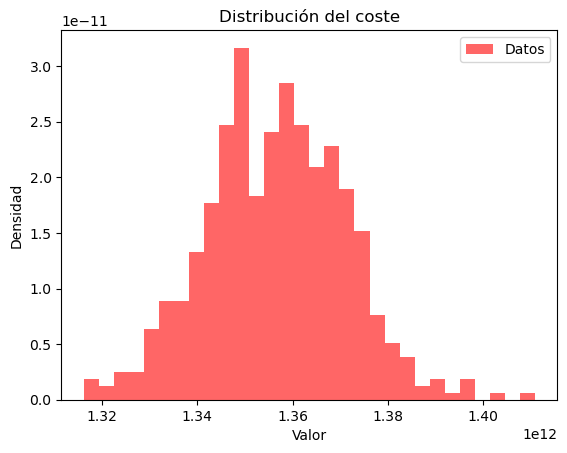

In [365]:
#Graficar el histograma

plt.hist(resp,bins=30, density=True, alpha=0.6,color='r',label='Datos')

plt.title(f'Distribución del coste')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()

##### Como el banco quiere ganar un 30%, el objetivo es igual al total por 0.3.Además el p inicial 0.3 no es el adecuado para cumplir dicho objetivo por lo que se debe modificar.

In [367]:
total= data['Valoracion'].sum()
objetivo=total*0.3

In [368]:
cuantil_95 = np.percentile(resp, 89)
ahorro = total-cuantil_95
ahorro

590869962987.0298

In [369]:
print(f"El ahorro esperado es de: {ahorro:.2f}")

El ahorro esperado es de: 590869962987.03


In [370]:
cuantil_95

1374522972534.519

In [371]:
objetivo

589617880656.4646

In [372]:
total

1965392935521.5488

In [350]:
ahorro>=objetivo

False

##### Al hacer pruebas con d=0.7 se evidencio que el factor de descuenta era muy alto y no permitiá lograr alguna ganancia del 30%. Por lo tanto, se toma d=0.5 y se dertermina p

In [373]:
p = objetivo / [(1-0.5)*total]
p

array([0.6])

##### De esta manera el P minímo para que el banco obtenga una ganancia es de 0.62, considerando un percentil del 89.

Con P = 0.62 y un percentil del 89, el banco puede garantizar que, en promedio, su flujo de pagos le genere una ganancia positiva.